In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Running on TPU  grpc://10.114.167.98:8470
Number of replicas: 8


In [ ]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 85
#ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 5


#if not os.path.exists(ARTIFACTS_PATH):
    #os.makedirs(ARTIFACTS_PATH)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/thesis/DATA/final+noise.csv',delimiter=',',encoding='latin-1')
df.head()

,tweet_text,New_label,Help_or_nonHelp,Spe_or_nonSpe,length
0,RT @lilid426: Everyone has all these intense r...,irrelevant,nonHelp,None,24
1,@kkfred12 @StayDvpper oh yea I would like to t...,irrelevant,nonHelp,None,23
2,"RT @fruitpopniall: ""1D are about to split up"" ...",irrelevant,nonHelp,None,10
3,@Harry_Styles You are my Ã¢ÂÂ You Ã°ÂÂ...,irrelevant,nonHelp,None,26
4,"RT @abonetti420: Swinging blunts round, sun up...",irrelevant,nonHelp,None,10


In [ ]:
df.rename(columns = {'new_label':'New_label'}, inplace = True)
df.rename(columns = {'text':'tweet_text'}, inplace = True)
df=df.dropna()

In [ ]:
df['length'] = df['tweet_text'].apply(lambda x : len(x.split()))

In [ ]:
df['length'].describe()

count    33098.000000
mean        19.426340
std         10.373971
min          0.000000
25%         12.000000
50%         18.000000
75%         24.000000
max        116.000000
Name: length, dtype: float64

In [ ]:
df

,tweet_text,New_label,Help_or_nonHelp,Spe_or_nonSpe,length
0,RT @lilid426: Everyone has all these intense r...,irrelevant,nonHelp,None,24
1,@kkfred12 @StayDvpper oh yea I would like to t...,irrelevant,nonHelp,None,23
2,"RT @fruitpopniall: ""1D are about to split up"" ...",irrelevant,nonHelp,None,10
3,@Harry_Styles You are my Ã¢ÂÂ You Ã°ÂÂ...,irrelevant,nonHelp,None,26
4,"RT @abonetti420: Swinging blunts round, sun up...",irrelevant,nonHelp,None,10
...,...,...,...,...,...
33093,says still mass downloading http://plurk.com/...,irrelevant,nonHelp,None,5
33094,Free fallin.... John Mayor is amazing,irrelevant,nonHelp,None,6
33095,really fancies a bike ride :/ yet my bike was ...,irrelevant,nonHelp,None,13
33096,@katiesol @brokenbottleboy I'm going to have t...,irrelevant,nonHelp,None,16


In [ ]:
X_data = df[['tweet_text']].to_numpy().reshape(-1)
y_data = df[['New_label']].to_numpy().reshape(-1)

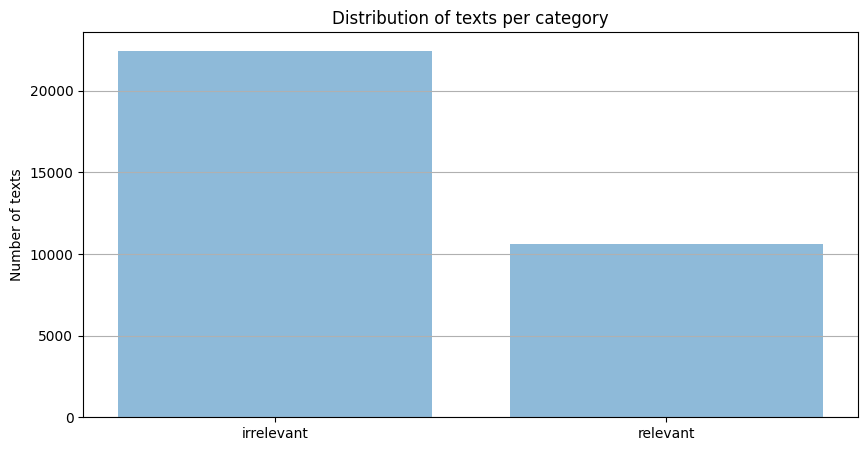

Counter({'irrelevant': 22458, 'relevant': 10640})


In [ ]:
categories = df[['New_label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
def calculate_stats(df, split_char=' '):
    categories = df['New_label'].unique()

    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['tweet_text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)

        category = row['New_label']

        all_lengths.append(l)
        per_category['lengths'][category].append(l)

    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }

    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['New_label'].unique()
    n_rows = math.ceil(len(categories) / n_cols)

    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')

    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [ ]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
irrelevant,"[24, 23, 10, 26, 10, 16, 23, 14, 19, 13, 19, 1...",19.660299,11.209418
relevant,"[18, 16, 20, 12, 9, 15, 17, 19, 22, 16, 12, 10...",19.429699,7.937730


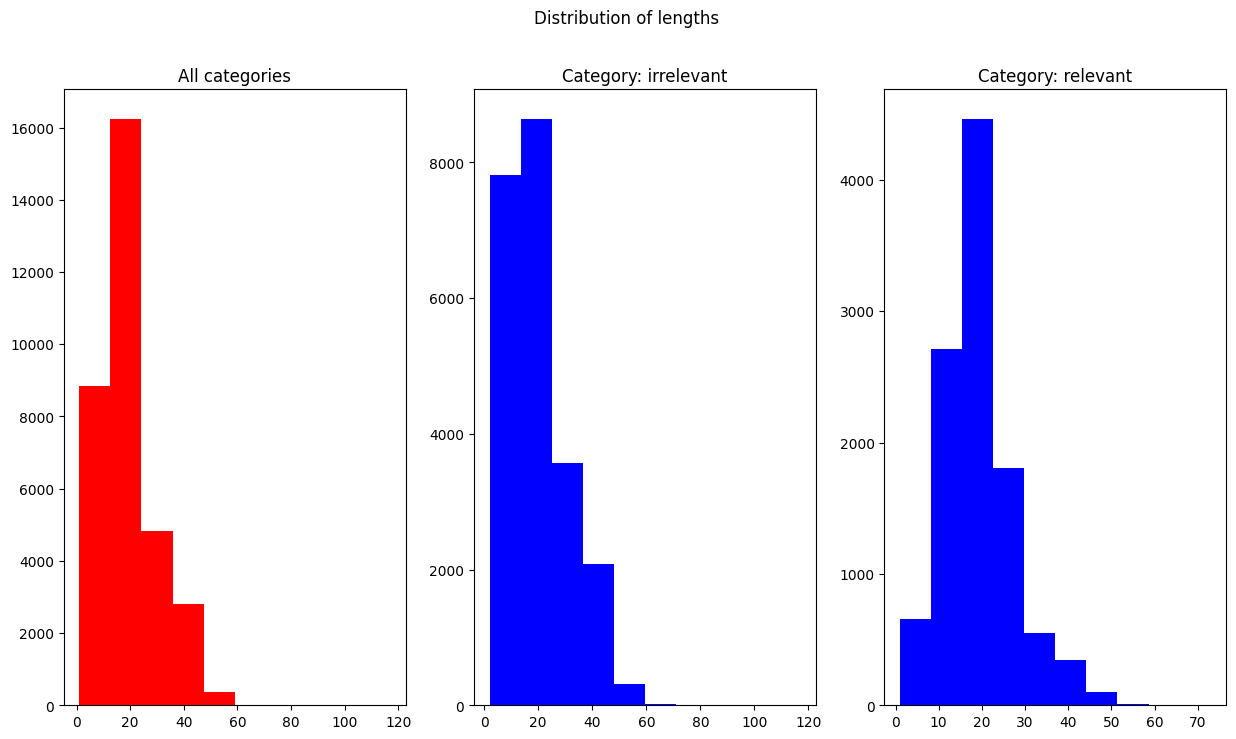

In [ ]:
display_lengths_histograms(df_stats)

In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['New_label'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 33098
Number of categories: 2
Done!


In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c

    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'irrelevant', 1: 'relevant'}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=777)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=777)
# random_state to reproduce results

In [ ]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)
X_val= roberta_encode(X_val, tokenizer)
y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')
y_val = np.asarray(y_val, dtype='int32')

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        roberta_model.layers[0].trainable = False

        """
        for p in roberta_model.base_model.parameters():
          p.requires_grad = False
        """

        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        x = tf.keras.layers.Dense(4, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-3),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [ ]:
bertModel = build_model(2)
bertModel.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 85)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 85)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 85)]         0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_mask[0][0]',       

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
"""early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

with strategy.scope():
    print('Training...')
    history = bertModel.fit(X_train,
                            y_train,
                            epochs=10,
                            batch_size=BATCH_SIZE,
                            verbose=1,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping])"""
with strategy.scope():
    print('Training...')
    history = bertModel.fit(X_train,
                        y_train,
                        epochs=5,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_val, y_val))

Training...
Epoch 1/5
415/415 [==============================] - 81s 111ms/step - loss: 0.2583 - accuracy: 0.8949 - val_loss: 0.2196 - val_accuracy: 0.9194
Epoch 2/5
415/415 [==============================] - 23s 56ms/step - loss: 0.1830 - accuracy: 0.9258 - val_loss: 0.1853 - val_accuracy: 0.9280
Epoch 3/5
415/415 [==============================] - 23s 56ms/step - loss: 0.1600 - accuracy: 0.9366 - val_loss: 0.1887 - val_accuracy: 0.9283
Epoch 4/5
415/415 [==============================] - 23s 56ms/step - loss: 0.1374 - accuracy: 0.9469 - val_loss: 0.1996 - val_accuracy: 0.9301
Epoch 5/5
415/415 [==============================] - 23s 56ms/step - loss: 0.1191 - accuracy: 0.9530 - val_loss: 0.2151 - val_accuracy: 0.9292


In [ ]:
bertModel.save('/content/drive/MyDrive/thesis/models/roberta_model10.h5')

In [ ]:
import transformers
bertModel = tf.keras.models.load_model('/content/drive/MyDrive/thesis/models/roberta_model.h5', custom_objects={"TFRobertaModel": transformers.TFRobertaModel})

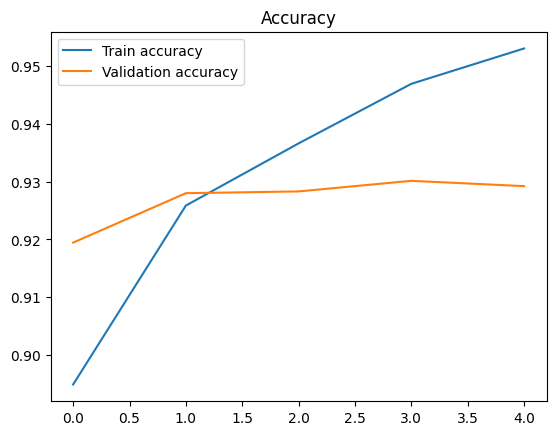

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.title('Accuracy')
xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train accuracy')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

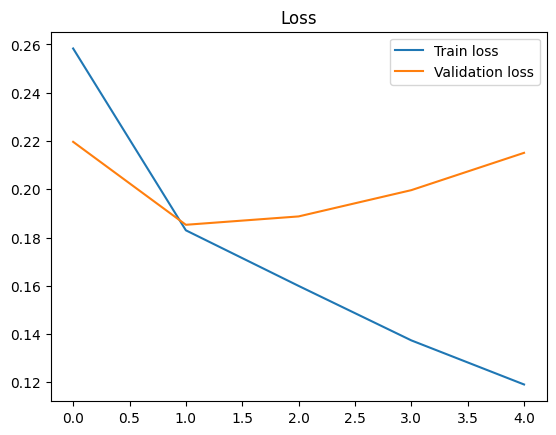

In [ ]:
plt.title('Loss')
xaxis = np.arange(len(history.history['loss']))
plt.plot(xaxis, history.history['loss'], label='Train loss')
plt.plot(xaxis, history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names,
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
scores = bertModel.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 92.33%


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)


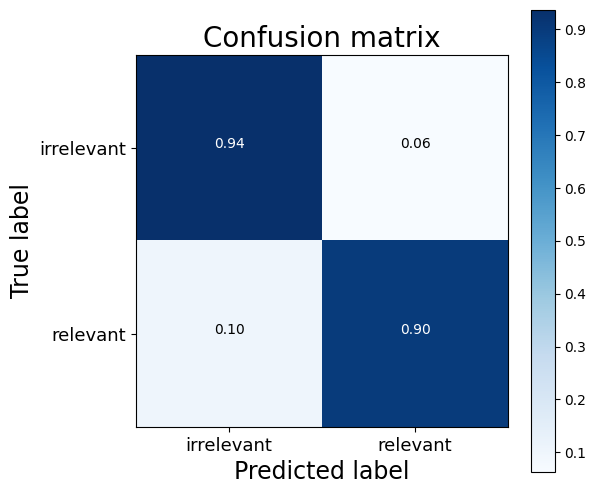

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=["irrelevant", "relevant"], title="Confusion matrix")
plt.show()

In [ ]:
! pip install --upgrade scikit-learn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(X_test, y_test, bertModel)

In [ ]:
from sklearn.metrics import classification_report
predictions = bertModel.predict(X_test)

104/104 [==============================] - 81s 749ms/step


In [ ]:
y_true = y_test.tolist()
y_pred = [np.argmax(pred) for pred in predictions]

class_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2196
           1       0.88      0.90      0.89      1114

    accuracy                           0.92      3310
   macro avg       0.91      0.92      0.91      3310
weighted avg       0.92      0.92      0.92      3310



In [ ]:
positive_prob=[]
for i in range(len(predictions)):
  positive_prob.append(predictions[i][1])

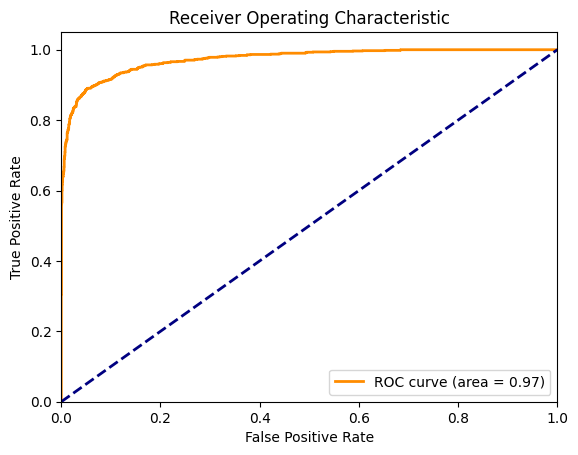

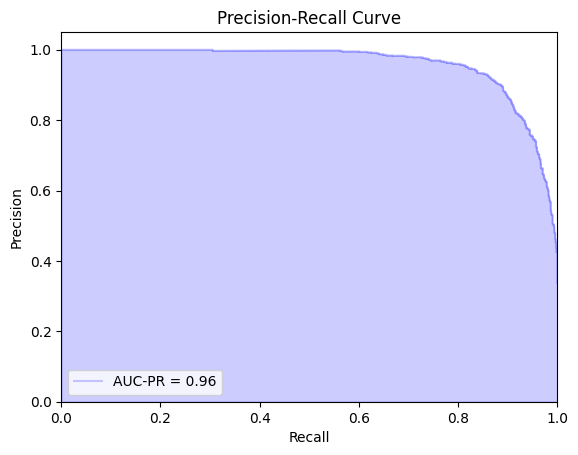

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming you have predicted probabilities and true labels for your model
predicted_probabilities = positive_prob# Predicted probabilities of positive class
true_labels = y_true # True labels (0 or 1) for the corresponding instances

# ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-recall curve
precision, recall, _ = precision_recall_curve(true_labels, predicted_probabilities)
pr_auc = auc(recall, precision)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(['AUC-PR = %0.2f' % pr_auc])
plt.show()
